# Kapitel 5 - Evaluation

## 5.1. Kapitelübersicht <a class="anchor" id="5-1"/>

Eine Evaluation eines Klassifizierungsverfahren ist notwendig, um es bewerten und mit anderen Klassifizierungsverfahren vergleichen zu können. TODO

<b>Abschnittsübersicht</b><br>

[5.1. Kapitelübersicht](#5-1)<br>
[5.2. ...](#5-2)<br>
[5.3. ...](#5-3)<br>

## 5.2. Trainings- und Testdatensatz

TODO?: WIEDERHOLUNG: wie funktioniert machine learning?

Bei den meisten Evaluationstechniken wird eine Bewertung für ein Textklassifikation berechnet, indem der Datensatz in einen <b>Trainings- und Testdatensatz</b> (auch Evaluationsdatensatz genannt) unterteilt wird. Das Klassifikationsverfahren wird dabei wie gewohnt auf den Trainingsdatensatz angewendet. Beim Testdatensatz werden die <i>Labels</i> (deutsch: Beschriftungen; im unseren Fall die Wikipediakategorien) entfernt und das Klassifikationsmodell muss diese Labels generieren. Die generierten Labels werden dann mit den tatsächlichen Labels des Testdatensatzes verglichen. Basierend darauf wird ein <b>score</b> (deutsch: Punktzahl) berechnet, der angibt, wie gut ein erlerntes Klassifikationsmodell neue Daten klassifizieren kann.<br>
Der Testdatensatz muss dabei das gleiche Format wie der Trainingsdatensatz haben. Inhaltlich muss sich der Testdatensatz jedoch von dem Trainingsdatensatz unterscheiden, d.h. es sollen keine Teildatensätze im Testdatensatz wiederverwendet werden. Im schlimmsten Fall würden wir den Trainingsdatensatz einfach als Testdatensatz wiederverwenden und das Klassifikationsmodell würde sich einfach die Datensätze "merken". Der zentrale und wichtige Schritt der Verallgemeinerung entfällt. Dies würde zu einem sehr guten <b>score</b> führen, der jedoch verfälscht ist. Bei der Voraussage von neuen Datensätze würde unser Klassifikationsmodell dann vermutlich sehr schlechte Voraussagen treffen, obwohl der score sehr gut war.

#### Laden des Korpus

In [2]:
import pandas as pd
corpus = pd.read_csv("tutorialdata/corpora/wikicorpus_v2.csv", index_col=0)
corpus.head()

,id,category,length,text
0,3470,Album nach Typ,1050,All the Best ! ( englisch Alles Gute ! ) ist d...
1,3611,Album nach Typ,525,Let It Roll : Songs by George Harrison ist das...
2,3612,Album nach Typ,251,Lieder wie Orkane ist das dritte offizielle Be...
3,3613,Album nach Typ,756,Long Stick Goes Boom : The Anthology ist eine ...
4,3614,Album nach Typ,260,Los Grandes Éxitos en Español ( spanisch für D...


#### Teilung in Trainings- und Testdatensatz

Wie gewohnt kodieren und vektorisieren wir unsere Labels und unsere Textdaten. Hierbei wurde der Code dafür etwas abgekürzt.

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

labels = LabelEncoder().fit_transform(corpus["category"])
vector = TfidfVectorizer().fit_transform(corpus["text"])

Nun schauen wir uns die Dimensionen der Matrix unseres vektorisierten Textes an. `shape` gibt uns die Dimensionen der Matrix als Tupel `(n,m)` zurück. `n` steht für die Zeilen der Matrix, `m` für die Spalten. 

In [4]:
vector.shape

(6000, 281396)

Nun wollen wir diese Daten teilen. Da eine Zeile für einen Wikipediaartikel steht, müssen wir uns an der ersten Zahl im Tupel orientieren. Das Verhältnis, wie wir die Daten teilen, soll hier 80% Trainingsdaten und 20% Testdaten sein. Die Bezeichnung "X" für die Textdaten und die Bezeichnung "y" für die Labels ist typisch und wird auch so von Scikit learn in der Dokumentation genutzt. Dass das X großgeschrieben wird ist eine Konvention, die zeigt, dass es sich hier um eine Matrix handelt. Vektoren wie y werden kleingeschrieben.

In [17]:
X_train = vector[:int(6000*0.8)]
y_train = labels[:int(6000*0.8)]
X_test = vector[int(6000*0.8):]
y_test = labels[int(6000*0.8):]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4800, 281396)
(4800,)
(1200, 281396)
(1200,)


<div class="alert alert-info">
<b>Exkurs:</b> Verhältnis von Trainings- und Testdaten
    
- 80/20: https://de.wikipedia.org/wiki/Paretoprinzip
- allgemein: https://stackoverflow.com/questions/13610074/is-there-a-rule-of-thumb-for-how-to-divide-a-dataset-into-training-and-validatio
- variance: https://machinelearningmastery.com/how-to-reduce-model-variance/
- bias/variance: https://machinelearningmastery.com/gentle-introduction-to-the-bias-variance-trade-off-in-machine-learning/

Für die Einteilung gibt es eine von Scikit learn integrierte Funktion `train_test_split`, die die Daten in zufällige Trainings- und Testdatensätze unterteilt. Dort kann man das Verhältnis des Trainings- und Testdatensatzes (`train_size`, `test_size`) angeben, die einzelen Daten auch mischen, bevor sie geteilt werden (`shuffle=False`) oder einen Seed für den Zufallsgenerator setzen (`random_state`). Der Parameter `train_size` muss nur zwingend angegeben werden, wenn es `test_size` nicht ergänzen soll (also beide zusammen nicht 1.0 ergeben sollen). Im Folgenden wird für die restliche Tutorial-Reihe immer die Zahl "42" für den Parameter `random_state` gewählt (außer eine Änderung wird explizit erwähnt), damit die Ergebnisse reproduzierbar sind. Die Zahl selbst ist dabei egal, solange sie die gleiche ist.

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(vector, 
                                                    labels, 
                                                    test_size=0.2, 
                                                    train_size=0.8,
                                                    random_state=42)

Nun setzen wir unsere Daten in unser Klassifizierungsverfahren ein. Anstatt den vektorisierten Daten `vector` und den kodierten Labels `labels` übergeben wir nun die vektorisierten Trainingsdaten `X_train` und die kodierten Trainingslabels `y_train`. Die Variable `y_pred` enthält die Voraussagen, die das Klassizierungsverfahren anhand der Trainingsdaten auf(?) die Testdaten getroffen hat. Um zu sehen, wieviele Labels richtig zugeordnet wurden, berechnen wir das <b>arithmetische Mittel</b> der Vektoren `y_pred` und `y_test`. Der Mittelwert gibt hier an, wieviel Prozent der Labels richtig zugeordnet wurden. 

In [36]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

import numpy as np


# Multinomial Naive Bayes
classifier = MultinomialNB()
mnb = classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

a = 0
for i, j in zip(y_test, y_pred):
    if i == j:
        a+=1

print(np.mean(y_pred == y_test))

0.87


<div class="alert alert-info">
<b>Exkurs:</b> Arithmetisches Mittel
    
Das <b>Arithmetische Mittel</b> ist eines der drei Varianten des <b>Mittelwerts</b>. Es wird berechnet, indem alle gegebenen Werte durch die Anzahl der Werte geteilt werden.<br><br>

$ \overline{x} = \frac{1}{n} \sum\nolimits_{i=1}^n x_i = \frac{x_1 + x_2 + ... + x_n}{n} $ <br><br>

## 5.3. Classification accuracy

Die <b>Classification accuracy</b> (oder auch nur <b>accuracy</b>) wird folgendermaßen berechnet:<br>

<u>Formel (allgemein)</u>:<br>
$  \text{Classification accuracy} = \frac{\text{Anzahl der korrekten Voraussagen}}{\text{Gesamtanzahl aller Voraussagen}} $<br>

<u>Formel (mathematisch)</u>:<br>
$\text{Classification accuracy}(y, \hat{y}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples}-1} 1(\hat{y}_i = y_i)$<br><br>

Die Formel scheint auf dem ersten Blick dem <b>arithmetischen Mittel</b> zu ähneln, hat aber einen entscheidenden Unterschied:
- Das <b>Arithmetische Mittel</b> ist ein Maß, das den <i>Durchschnitt</i> einer Reihe von Zahlen angibt.
- Die <b>Classification Accuracy</b> ist ein Maß, das zwei Zahlenreihen miteinander <i>vergleicht</i> und angibt, wie hoch die Übereinstimmung ist.

<u>Beispiel</u>:<br>
Zwei kodierte Labelvektoren werden miteinander verglichen. Es soll berechnet werden, wieviele gemeinsame Labels die beiden Vektoren haben. Haben sie ein gemeinsames Label, erhält die Schnittstelle den Wert "1", ansonsten eine "0".<br>
$ v_1 = (1, 1, 2, 5, 3, 4, 4) $<br>
$ v_2 = (1, 2, 2, 5, 4, 4, 3) $<br>

$ \text{Alle Voraussagen}: 1==1,\ 1==2,\ 2==2,\ 5==5,\ 3==4,\ 4==4,\ 4==3 $<br>
$ \text{Anzahl der korrekten Voraussagen}: 1 + 0 + 1 + 1 + 0 + 1 + 0 = 4 $<br>
$ \text{Gesamtanzahl aller Voraussagen}: 7 $<br>

$ \text{Classification accuracy} = \frac{4}{7} = 0.57$<br>

In Scikit learn wird die Classification accuracy folgendermaßen berechnet.

In [43]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.87


Die Classification accuracy ist nur bedingt als Evaluationsmaß nützlich. Wichtige Details, die zum besseren Verständnis der Leistung eines Klassifikationsmodell nötig wären, werden ausgeblendet. Dies wird in zwei Fällen deutlich:<br>
1. Sogenannte <b>unausgeglichen Datensätzen</b> (englisch: imbalanced datasets), bei denen die Daten keine gerade Anzahl an Klassen haben, sind problematisch: Ist die Classification accuracy 90%, aber 90 von 100 Datensätzen sind einer Klasse zugeordnet, kann genau die gleiche Genauigkeit auch erreicht werden, wenn man einfach für jeden Datensatz die häufigste Klasse voraussagt.[<sup>1</sup>](#fn1) Die accuracy scheint hoch zu sein, im Hinblick auf die Verteilung der Klassen ist sie jedoch nicht besonders gut.
2. Bei der <b>Multiclass classification</b> kann bei einem Ergebnis von z.B. 85% nicht gesagt werden, ob alle Klassen gleich gut vorhergesagt wurden oder ob eine oder zwei Klassen vom Klassifizierungsmodell vernachlässigt wurden.
 

Unser Datensatz ist ausgeglichen, da zu jeder Kategorie gleich viele Artikel gehören (immer genau 200 Artikel). Jedoch benutzen wir Multiclass classification, weshalb die Classification accuracy als Evaluationsmethode für unseren Datensatz nicht uneingeschränkt genutzt werden kann.

<hr style="border: 0.1px solid black;"/>
<span id="fn1" style="font-size:8pt; line-height:1"><sup style="font-size:5pt">1</sup> &nbsp; Dieses Problem wird auch <a href=https://en.wikipedia.org/wiki/Accuracy_paradox>Accuracy paradox</a> genannt. Ein sehr anschauliches Beispiel dafür bietet dieser <a href="https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c">Medium-Artikel</a>.</span>

## 5.4. Confusion Matrix

Eine Möglichkeit, die Ergebnisse der Voraussagen eines Klassifikationsverfahren zu visualisieren, ist eine <b>Confusion Matrix</b> (deutsch: Wahrheitsmatrix). Diese Matrix ist ein spezifisches Tabellenlayout, bei der die Anzahl der korrekten und inkorrekten Vorhersagen wird mit Zählwerten zusammengefasst und anhand der Klassen aufgeteilt wird.<br>

> The confusion matrix shows the ways in which your classification model is confused when it makes predictions."[<sup>2</sup>](#fn2) - <i>Jason Brownlee</i>
    

<hr style="border: 0.1px solid black;"/>
<span id="fn1" style="font-size:8pt; line-height:1"><sup style="font-size:5pt">2</sup> &nbsp; Siehe den Blogeintrag <a href="https://machinelearningmastery.com/confusion-matrix-machine-learning/">What is a Confusion Matrix in Machine Learning</a>.</span>    


Um die Confusion Matrix besser zu verstehen, soll sie zunächst erzeugt werden. In Scikit learn ist eine Confusion Matrix Visualisierung implementiert, die jedoch nicht besonders anschaulich ist.

In [49]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix[:10] #verkürzte Darstellung, damit der Output nicht zu groß wird

array([[46,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 43,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 51,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0, 29,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  0,
         1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 31,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  2,  0,  0, 20,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,
         7, 10,  0,  0,  0,  0,  0,  0,  1,  0,  7,  0,  0,  3],
       [ 0,  0,  0,  0,  0,  0, 39,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0, 41,  

TODO<br>


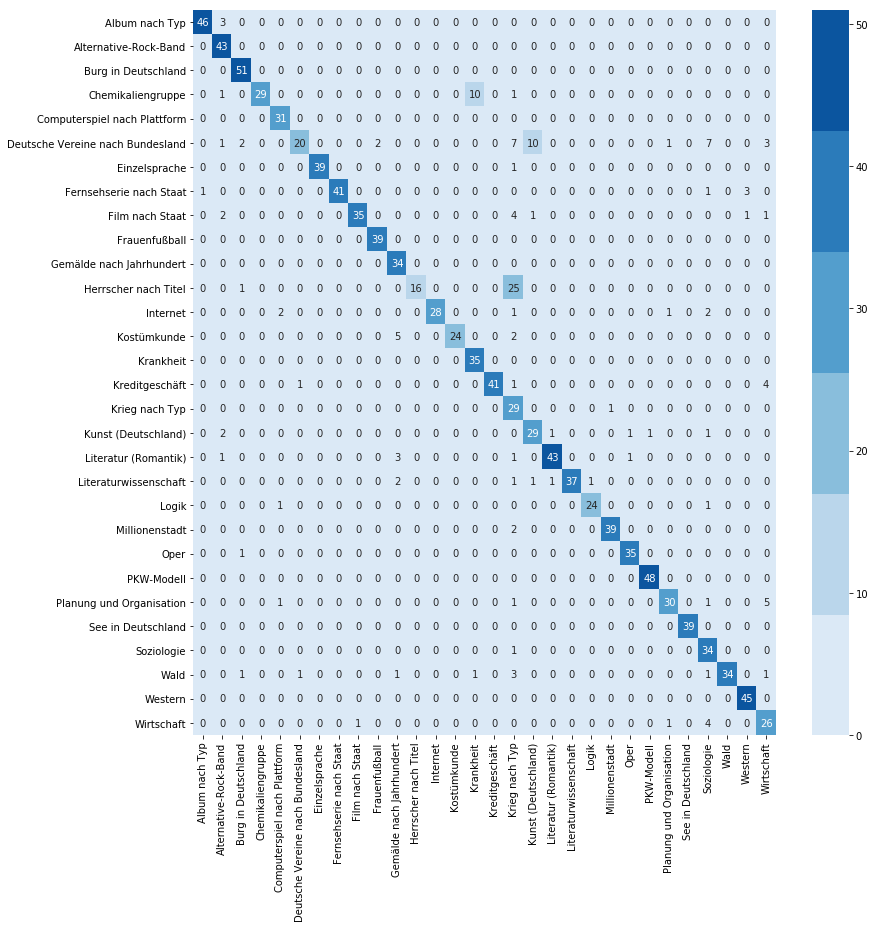

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

# Die Original Kategorienbezeichnungen
classes = corpus["category"].drop_duplicates().tolist()

# Ein DataFrame mit den Kategorienbezeichnungen als Reihen und Spalten
cnf_df = pd.DataFrame(cnf_matrix, index=classes, columns=classes)
    
plt.figure(figsize=(13, 13))
sns.heatmap(cnf_df, annot=True, cmap=sns.color_palette("Blues"))
plt.tight_layout()

- allgeimen: https://machinelearningmastery.com/confusion-matrix-machine-learning/
- alggemein: https://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/
- mutliclass: https://stats.stackexchange.com/questions/318780/how-to-understand-confusion-matrix-for-3x3
- multiclass: https://stats.stackexchange.com/questions/179835/how-to-build-a-confusion-matrix-for-a-multiclass-classifier
- true positive: https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c
- true positive: https://tryolabs.com/blog/2013/03/25/why-accuracy-alone-bad-measure-classification-tasks-and-what-we-can-do-about-it/
- true positive: https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/
-true positive for multiclass: https://stackoverflow.com/questions/50666091/true-positive-rate-and-false-positive-rate-tpr-fpr-for-multi-class-data-in-py

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

labels = LabelEncoder().fit_transform(corpus["category"])
vector  = TfidfVectorizer().fit_transform(corpus["text"])

# Multinomial Naive Bayes
classifier = MultinomialNB()
mnb = classifier.fit(vector, labels)

# Unser Testsatz
vector2 = vectorizer.transform(["Ein sehr knappes Spiel"])

# Die Voraussage
prediction = mnb.predict(vector2)
#print(prediction)
original_predicted_category = encoder.inverse_transform(prediction)
print(str(original_predicted_category))

NameError: name 'vectorizer' is not defined

orientieren an: https://monkeylearn.com/text-classification/ (metrics and evaluation)

mnb.score(vector, labels) #nächstes kapitel!

vllt. hilfreich?:

- vorteil one hot encoding: https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/


https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f


https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

https://stackabuse.com/text-classification-with-python-and-scikit-learn/